# 乱序拼图验证的识别并还原

## 一、前言

乱序拼图验证是一种较少见的验证码防御，市面上更多的是拖动滑块，被完美攻克的有不少，都在行为轨迹上下足了功夫，本文不讨论轨迹模拟范畴，就只针对拼图还原进行研究。

![](docs/2.png)

找一个市面比较普及的顶像乱序拼图进行验证，它号称的`防御能力4星`，`用户体验3星`，通过研究发现，它的还原程度相当高，思路也很简单，下面一步步的讲解还原过程。

![](docs/x.gif)

## 二、环境准备

### 1.依赖

- 采集模拟 `selenium`

- 特征匹配 `python`+`opencv`

### 2.安装环境

In [1]:
!pip install setuptools
!pip install selenium
!pip install numpy Matplotlib
!pip install opencv-python

### 3.chormedriver 下载

找到对应`浏览器版本+系统平台`的`driver`后，`macOS` 建议存放到 `/usr/local/bin`

!wget https://npm.taobao.org/mirrors/chromedriver/95.0.4638.69/chromedriver_mac64.zip

## 三、采集样本

引入依赖库，使用 `webdriver` 打开官方网站的产品演示页面

![](docs/1.png)

In [2]:
import os
import cv2
import time
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait

创建下载样本的代码，主要流程是打开官网的demo页后，截图并保存

![](docs/3.png)

In [3]:
# 采集代码
class CrackPuzzleCaptcha():
    # 初始化webdriver
    def init(self):
        self.url = 'https://www.dingxiang-inc.com/business/captcha'
        chrome_options = webdriver.ChromeOptions()
        # chrome_options.add_argument("--start-maximized")
        chrome_options.add_experimental_option("excludeSwitches", ["ignore-certificate-errors","enable-automation"]) # 设置为开发者模式
        path = r'/usr/local/bin/chromedriver' #macOS
#         path = r'D:\Anaconda3\chromedriver.exe' #windows
        self.browser = webdriver.Chrome(executable_path=path,chrome_options=chrome_options)
        #设置显示等待时间
        self.wait = WebDriverWait(self.browser, 20)
        self.browser.get(self.url)
    # 打开验证码demo页面，并强制元素在浏览器可视区域
    def openTest(self):
        time.sleep(1)
        self.browser.execute_script('setTimeout(function(){document.querySelector("body > div.wrapper-main > div.wrapper.wrapper-content > div > div.captcha-intro > div.captcha-intro-header > div > div > ul > li.item-8").click();},0)')
        self.browser.execute_script('setTimeout(function(){document.querySelector("body > div.wrapper-main > div.wrapper.wrapper-content > div > div.captcha-intro > div.captcha-intro-body > div > div.captcha-intro-demo").scrollIntoView();},0)')
        time.sleep(1)
    # 找到原图，webp格式，直接下载保存
    def download(self):
        onebtn = self.browser.find_element_by_css_selector('#dx_captcha_oneclick_bar-logo_2 > span')
        ActionChains(self.browser).move_to_element(onebtn).perform() 
        time.sleep(1)
        #下载webp
        img_url = self.browser.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-left_3 > img').get_attribute("src")
        img_address = "test.png" # 样本文件
        response = urllib.request.urlopen(img_url)
        img = response.read()
        with open(img_address, 'wb') as f:
            f.write(img)
            print('已保存', img_address)
        return self.browser
            
    def crack(self):
        pass

开始采集

In [4]:
crack = CrackPuzzleCaptcha()
crack.init()
crack.openTest()

<ipython-input-3-986d3d0cf219>:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.browser = webdriver.Chrome(executable_path=path,chrome_options=chrome_options)
<ipython-input-3-986d3d0cf219>:11: DeprecationWarning: use options instead of chrome_options
  self.browser = webdriver.Chrome(executable_path=path,chrome_options=chrome_options)


In [5]:
browser2 = crack.download()

<ipython-input-3-986d3d0cf219>:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  onebtn = self.browser.find_element_by_css_selector('#dx_captcha_oneclick_bar-logo_2 > span')


已保存 test.png


<ipython-input-3-986d3d0cf219>:27: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  img_url = self.browser.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-left_3 > img').get_attribute("src")


## 四、调研结果


- 关键1:显示的拼图的原图就是`已经乱序`的状态

- 关键2:原图是一个整体，那么获取原图`切割并编号`，能得到与拼图过程一致的结果

- 关键3:拼图只需要做`1`次换位即可，`2x2`的矩阵，可以对`[1,2,3,4]`进行排列组合，得到所有的拼接结果


## 五、分析过程

### 1.辅助函数

定义辅助函数，方便获取参数

In [29]:
# 显示图形
def show_images(images: list , title = '') -> None:
    if title!='':
        print(title)
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])
    plt.show(block=True)
    
# 获取图像的基本信息
def getSize(p):
    sum_rows = p.shape[0]
    sum_cols = p.shape[1]
    channels = p.shape[2]
    return sum_rows,sum_cols,channels

### 2.图像切割

样本图 高度、宽度、通道 150 300 3
四图切分，求原图中心位置 75 150
切割为4个小块的 W/H/C 信息，并四图编号：左上=1，右上=2，左下=3，右下=4
 (75, 150, 3) (75, 150, 3) (75, 150, 3) (75, 150, 3)
原图


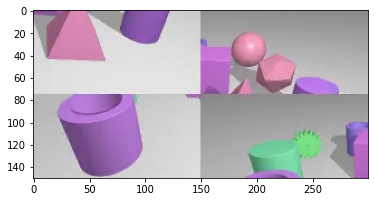

切割图


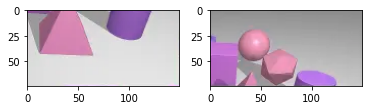

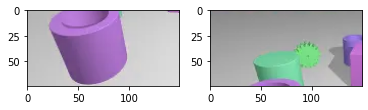

In [30]:
# 输入样本
file = 'test.png'
img = cv2.imread(file)

sum_rows,sum_cols,channels = getSize(img)
part_rows,part_cols = round(sum_rows/2),round(sum_cols/2)
print('样本图 高度、宽度、通道',sum_rows,sum_cols,channels)
print('四图切分，求原图中心位置',part_rows,part_cols)

part1 = img[0:part_rows, 0:part_cols]
part2 = img[0:part_rows, part_cols:sum_cols]
part3 = img[part_rows:sum_rows, 0:part_cols]
part4 = img[part_rows:sum_rows, part_cols:sum_cols]

print('切割为4个小块的 W/H/C 信息，并四图编号：左上=1，右上=2，左下=3，右下=4\n',getSize(part1),getSize(part2),getSize(part3),getSize(part4))

show_images([img],'原图')
show_images([part1,part2],'切割图')
show_images([part3,part4])


完成切割后，还需要重组合并4个图像，用于`匹配最佳结果`

### 3.图像拼接

In [31]:
# 拼接函数
def merge(sum_rows,sum_cols,channels,p1,p2,p3,p4):
    final_matrix = np.zeros((sum_rows, sum_cols,channels), np.uint8)
    part_rows,part_cols = round(sum_rows/2),round(sum_cols/2)

    final_matrix[0:part_rows, 0:part_cols] = p1
    final_matrix[0:part_rows, part_cols:sum_cols] = p2
    final_matrix[part_rows:sum_rows, 0:part_cols] = p3
    final_matrix[part_rows:sum_rows, part_cols:sum_cols] = p4
    return final_matrix

从编号上来看，应该将 `[1,2,3,4]` 还原成 `[4,2,3,1]` 就是正确的图，测试下还原效果

还原图 [4,2,3,1]


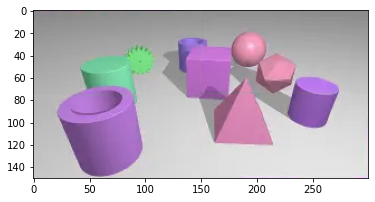

In [32]:
# 还原图 
f = merge(sum_rows,sum_cols,channels,part4,part2,part3,part1)
show_images([f],'还原图 [4,2,3,1]')

### 4.排列组合

已知 python 实现排列组合非常方便，测试代码如下

In [33]:
import itertools

# 对应拼图的4个块的编号
puzzle_list = [
    "1:左上","2:右下",
    "3:左下","4:右下"
]

result = itertools.permutations(puzzle_list,4)
cnt=0
for x in result:
    cnt+=1
    print(x)
print('共',cnt,'种组合')
    

('1:左上', '2:右下', '3:左下', '4:右下')
('1:左上', '2:右下', '4:右下', '3:左下')
('1:左上', '3:左下', '2:右下', '4:右下')
('1:左上', '3:左下', '4:右下', '2:右下')
('1:左上', '4:右下', '2:右下', '3:左下')
('1:左上', '4:右下', '3:左下', '2:右下')
('2:右下', '1:左上', '3:左下', '4:右下')
('2:右下', '1:左上', '4:右下', '3:左下')
('2:右下', '3:左下', '1:左上', '4:右下')
('2:右下', '3:左下', '4:右下', '1:左上')
('2:右下', '4:右下', '1:左上', '3:左下')
('2:右下', '4:右下', '3:左下', '1:左上')
('3:左下', '1:左上', '2:右下', '4:右下')
('3:左下', '1:左上', '4:右下', '2:右下')
('3:左下', '2:右下', '1:左上', '4:右下')
('3:左下', '2:右下', '4:右下', '1:左上')
('3:左下', '4:右下', '1:左上', '2:右下')
('3:左下', '4:右下', '2:右下', '1:左上')
('4:右下', '1:左上', '2:右下', '3:左下')
('4:右下', '1:左上', '3:左下', '2:右下')
('4:右下', '2:右下', '1:左上', '3:左下')
('4:右下', '2:右下', '3:左下', '1:左上')
('4:右下', '3:左下', '1:左上', '2:右下')
('4:右下', '3:左下', '2:右下', '1:左上')
共 24 种组合


### 5.特征提取

采用 merge 函数，对切割的小图进行`组合还原`后，转换为`灰度图`并`提取轮廓`。

还原图[1,2,3,4]


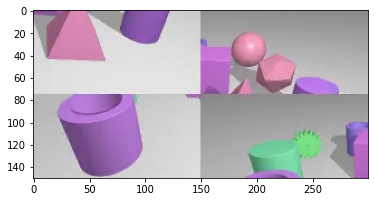

灰度


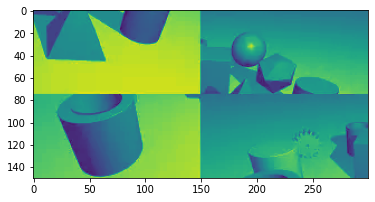

提取轮廓


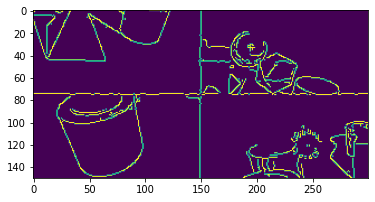

In [34]:
# 还原图 
f = merge(sum_rows,sum_cols,channels,part1,part2,part3,part4)
show_images([f],'还原图[1,2,3,4]')
# 灰度
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
show_images([gray],'灰度')
# 提取轮廓
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'提取轮廓')


再测试一种新的组合，看看轮廓特征[1,3,2,4]和原始的轮廓特征[4,2,3,1]

提取轮廓


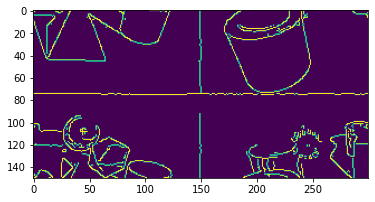

提取轮廓


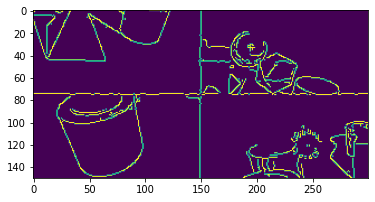

正确的-提取轮廓


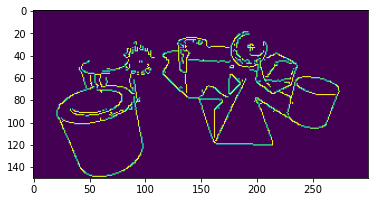

In [35]:
f = merge(sum_rows,sum_cols,channels,part1,part3,part2,part4)
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'提取轮廓')

f = merge(sum_rows,sum_cols,channels,part1,part2,part3,part4)
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'提取轮廓')

# 正确的
f = merge(sum_rows,sum_cols,channels,part4,part2,part3,part1)
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'正确的-提取轮廓')

通过提取轮廓，可以看到拼接结果的`明显的线条`，错误的图`至少存在一条x轴或y轴的线`，而拼接成功的基本没有（`线段位置或长度及线条数量可以决定正确率，需要多调整参数并筛选`）。

这是因为原图有明显的`过渡色`，它是为了用户体验而设计，方便人们使用它的时候，能够‘`容易`’的区分，并找出正确的拼图位置。

背景渐变色


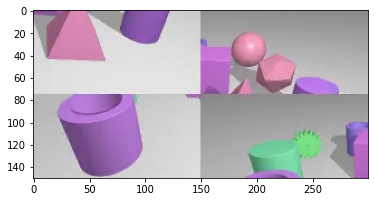

切割后


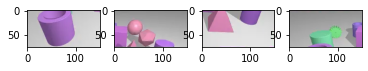

乱序，渐变色成为了‘十字’特征线


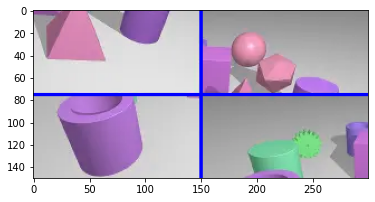

In [36]:
f = merge(sum_rows,sum_cols,channels,part1,part2,part3,part4)
show_images([f],'背景渐变色')
show_images([part3,part2,part1,part4],'切割后')
f = merge(sum_rows,sum_cols,channels,part1,part2,part3,part4)
lf = f.copy()
cv2.line(lf, (0, 75), (300, 75), (0, 0, 255), 2)
cv2.line(lf, (150, 0), (150, 150), (0, 0, 255), 2)
show_images([lf],'乱序，渐变色成为了‘十字’特征线')

### 6.特征匹配

特征已知后，现在剩下的就是对特征进行`检测`，可以计算 x/2,y/2 `十字架`的色差，也可以用 opencv 的`直线提取`，测试代码如下：

提取轮廓


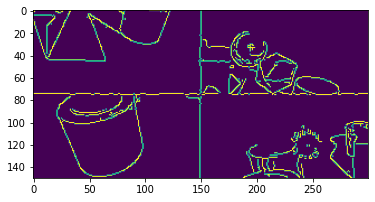

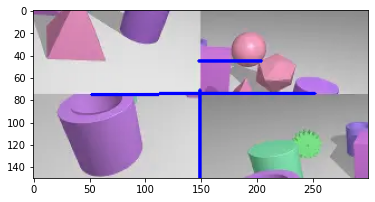

In [37]:
f = merge(sum_rows,sum_cols,channels,part1,part2,part3,part4)
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'提取轮廓')

lines = cv2.HoughLinesP(edges,0.01,np.pi/360,60,minLineLength=50,maxLineGap=10)
if lines is None:
    print('没找到线条')
else:
    lf = f.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lf, (x1, y1), (x2, y2), (0, 0, 255), 2)
    show_images([lf])

尝试正确的组合 [4,2,3,1]

提取轮廓


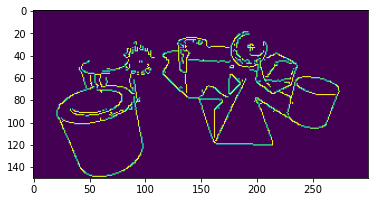

没找到线条


In [38]:
f = merge(sum_rows,sum_cols,channels,part4,part2,part3,part1)
gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
edges = cv2.Canny(gray, 35, 80, apertureSize=3)
show_images([edges],'提取轮廓')

lines = cv2.HoughLinesP(edges,0.01,np.pi/360,60,minLineLength=50,maxLineGap=10)
if lines is None:
    print('没找到线条')
else:
    lf = f.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lf, (x1, y1), (x2, y2), (0, 0, 255), 2)
    show_images([lf])

### 7.匹配过程

原图顺序
1 2
3 4


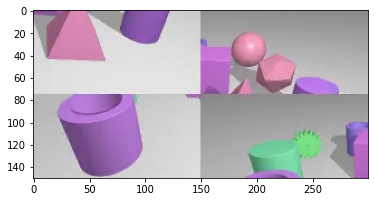

1 排列: 1 2 3 4 线: 4
2 排列: 1 2 4 3 线: 5
3 排列: 1 3 2 4 线: 4
4 排列: 1 3 4 2 线: 2
5 排列: 1 4 2 3 线: 3
6 排列: 1 4 3 2 线: 4
7 排列: 2 1 3 4 线: 3
8 排列: 2 1 4 3 线: 5
9 排列: 2 3 1 4 线: 3
10 排列: 2 3 4 1 线: 3
11 排列: 2 4 1 3 线: 1
12 排列: 2 4 3 1 线: 1
13 排列: 3 1 2 4 线: 2
14 排列: 3 1 4 2 线: 2
15 排列: 3 2 1 4 线: 3
16 排列: 3 2 4 1 线: 3
17 排列: 3 4 1 2 线: 5
18 排列: 3 4 2 1 线: 3
19 排列: 4 1 2 3 线: 4
20 排列: 4 1 3 2 线: 3
21 排列: 4 2 1 3 线: 2
还原图像


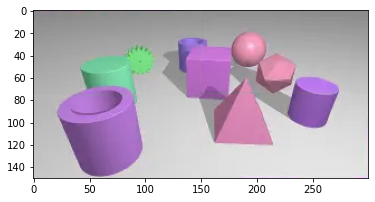

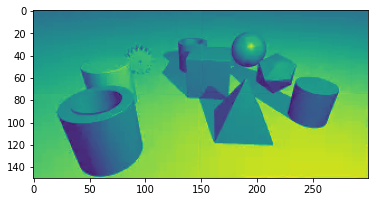

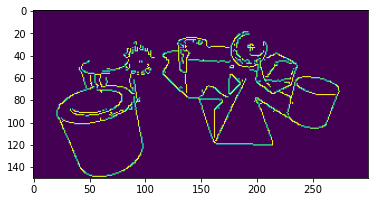

正确顺序
4 2
3 1
完成!!
测试次数 22 最终状态 True [4, 2, 3, 1]


In [39]:
import itertools

print('原图顺序')
print(1,2)
print(3,4)
show_images([img])

# 按编号，将切割的图放入list做排列组合
list1 = [
    [1,part1],
    [2,part2],
    [3,part3],
    [4,part4]
]

result = itertools.permutations(list1,4)
idx =1
finded = False
finalResult = []
for x in result:
    # 排列组合合并图像
    f = merge(sum_rows,sum_cols,channels,x[0][1],x[1][1],x[2][1],x[3][1])
    # 图像特征提取
    gray = cv2.cvtColor(f, cv2.COLOR_BGRA2GRAY)
    edges = cv2.Canny(gray, 35, 80, apertureSize=3)
    # 直线匹配
    lines = cv2.HoughLinesP(edges,0.01,np.pi/360,60,minLineLength=50,maxLineGap=10)
    if lines is None:
        print('还原图像')
        show_images([f])
        show_images([gray])
        show_images([edges])
        print('正确顺序')
        print(x[0][0],x[1][0])
        print(x[2][0],x[3][0])
        print('完成!!')
        finded = True
        finalResult =[x[0][0],x[1][0],x[2][0],x[3][0]] #获取最终排列正确的结果
        break
    else:
        print(idx, '排列:' , x[0][0],x[1][0],x[2][0],x[3][0] , '线:', len(lines))
        lf = f.copy()
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lf, (x1, y1), (x2, y2), (0, 0, 255), 2)
#         show_images([lf])
        pass
    idx+=1

print('测试次数',idx,'最终状态',finded,finalResult)

### 8.提取结果

再看看如何这种拼图，如果要`交换位置`的组合有12种

In [40]:
list1 = [1,2,3,4]

result = itertools.permutations(list1,2)
idx=0
for x in result:
    idx+=1
    print(idx,x)


1 (1, 2)
2 (1, 3)
3 (1, 4)
4 (2, 1)
5 (2, 3)
6 (2, 4)
7 (3, 1)
8 (3, 2)
9 (3, 4)
10 (4, 1)
11 (4, 2)
12 (4, 3)


In [41]:
#交换函数
def change_check(a,b):
    diffs = []
    if len(a)!=len(b):
        return diffs
    
    for i in range(len(a)):
        if a[i]!=b[i]:
            diffs.append(b[i])
    return diffs

ab = change_check([1,2,3,4],finalResult)
print('原始',[1,2,3,4])
print('最终',finalResult)
print('要交换的位置',ab)

原始 [1, 2, 3, 4]
最终 [4, 2, 3, 1]
要交换的位置 [4, 1]


将‘`交换的位置`’换算成`小图中心`的`偏移坐标`，采用`查表法`

In [42]:
#大图尺寸
pwidth = 150 
pheight = 75 
#小图xy中心点 = 大图wh 1/4
px = round(pwidth/2)
py = round(pheight/2)
#创建坐标表
offset_points = [
    [px,py],[px+pwidth,py],
    [px,py+pheight],[px+pwidth,py+pheight]
]
print(offset_points)
print(ab)
#通过结果作为索引，拿到坐标表索引的坐标
drag_start = offset_points[ ab[0] -1 ]
drag_end = offset_points[ ab[1] -1 ]

print('起点偏移坐标',drag_start,'终点偏移坐标',drag_end)

[[75, 38], [225, 38], [75, 113], [225, 113]]
[4, 1]
起点偏移坐标 [225, 113] 终点偏移坐标 [75, 38]


### 9.模拟操作

至此，已经完成了拼图还原的分析所有过程，下面采用另一种简单的方法，`move_to_element` 方法，内置的拖动 `dom-a 到 dom-b` 位置，测试下结果

In [43]:
# 模拟聚焦按钮，让拼图显示出来
onebtn = browser2.find_element_by_css_selector('#dx_captcha_oneclick_bar-logo_2 > span')
ActionChains(browser2).move_to_element(onebtn).perform() 
time.sleep(1)

<ipython-input-43-4540d81b7b77>:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  onebtn = browser2.find_element_by_css_selector('#dx_captcha_oneclick_bar-logo_2 > span')


NoSuchWindowException: Message: no such window: window was already closed
  (Session info: chrome=96.0.4664.55)
Stacktrace:
0   chromedriver                        0x00000001034a2519 __gxx_personality_v0 + 577193
1   chromedriver                        0x000000010342e663 __gxx_personality_v0 + 102387
2   chromedriver                        0x0000000102ff5d28 chromedriver + 171304
3   chromedriver                        0x0000000102fe5b31 chromedriver + 105265
4   chromedriver                        0x0000000102fe6ed2 chromedriver + 110290
5   chromedriver                        0x0000000102fdfc92 chromedriver + 81042
6   chromedriver                        0x0000000102ff71b3 chromedriver + 176563
7   chromedriver                        0x0000000103059f5c chromedriver + 581468
8   chromedriver                        0x00000001030480a3 chromedriver + 508067
9   chromedriver                        0x000000010301e5ae chromedriver + 337326
10  chromedriver                        0x000000010301f8d5 chromedriver + 342229
11  chromedriver                        0x000000010345e75f __gxx_personality_v0 + 299247
12  chromedriver                        0x000000010347569a __gxx_personality_v0 + 393258
13  chromedriver                        0x000000010347af5b __gxx_personality_v0 + 415979
14  chromedriver                        0x0000000103476a3a __gxx_personality_v0 + 398282
15  chromedriver                        0x000000010345337c __gxx_personality_v0 + 253196
16  chromedriver                        0x0000000103492458 __gxx_personality_v0 + 511464
17  chromedriver                        0x00000001034925e1 __gxx_personality_v0 + 511857
18  chromedriver                        0x00000001034a9968 __gxx_personality_v0 + 606968
19  libsystem_pthread.dylib             0x00007fff203688fc _pthread_start + 224
20  libsystem_pthread.dylib             0x00007fff20364443 thread_start + 15


获取最终结果

In [44]:
ab = change_check([1,2,3,4],finalResult)
print(ab)

[4, 1]


找到网页拼图的dom元素，存储下来用于操作并交换拼图

In [22]:
d1 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-left_3 > div')
d2 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-right_3 > div')
d3 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-bottom-left_3 > div')
d4 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-bottom-right_3 > div')
drag_elements = [d1,d2,d3,d4]

<ipython-input-22-61fb3f895e04>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  d1 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-left_3 > div')
<ipython-input-22-61fb3f895e04>:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  d2 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-top-right_3 > div')
<ipython-input-22-61fb3f895e04>:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  d3 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-bottom-left_3 > div')
<ipython-input-22-61fb3f895e04>:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  d4 = browser2.find_element_by_css_selector('#dx_captcha_jigsaw_fragment-bottom-right_3 > div')


找出要拖动的2个dom，并交付给 webdriver

In [23]:
drag_start = drag_elements[ ab[0] -1 ]
drag_end = drag_elements[ ab[1] -1 ]
print('drag_start',drag_start, 'drag_end',drag_end)

drag_start <selenium.webdriver.remote.webelement.WebElement (session="1d7d691bd509cd03cd8b1483da2056ea", element="8439005e-eb70-4b02-856e-eebbe2526d6d")> drag_end <selenium.webdriver.remote.webelement.WebElement (session="1d7d691bd509cd03cd8b1483da2056ea", element="f9239df5-9aa3-43ae-a6af-afacf81eb670")>


In [24]:
ActionChains(browser2).drag_and_drop(drag_start,drag_end).perform()
# browser2.close()

简单拖一下，目标网站认可了，但它判定是有问题的，又弹出一种新的验证码出来，看来仅仅能够识别还原正确拼图还只是开端，如何伪造一个让其认可的运行环境，又是一个新的技术研究领域，值得与各位共同学习与分享交流。

## 六、终

边学边做，如有`错误`之处敬请指出，谢谢！

项目地址：https://github.com/suifei/puzzle-captcha